# Identifying ghost hotels

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
from pysal.lib import weights

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from numbers import Number

In [2]:
#Using a dataset with pre-normalised descriptions to reduce computational intensity
norm_df = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/clean/2020-08-24-listings-with-nlp-subset.csv.gz?raw=true',
                compression='gzip', dtype={'id':np.float64, 'name':str, 'listing_url':str, 'name':str, 'description':str, 'description_norm':str})

#Dataset with additional info
ref_df = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/2020-08-24-listings.csv.gz?raw=true',
                    compression='gzip', usecols=['id', 'room_type', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'host_id', 'host_name', 'latitude', 'longitude', 'price', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'minimum_nights'],
                    dtype={'id':np.float64,
                           'room_type':str, 
                           'calculated_host_listings_count':np.float64,
                           'calculated_host_listings_count_entire_homes':np.float64,
                           'calculated_host_listings_count_private_rooms':np.float64,
                           'host_id':np.float64, 
                           'host_name':str, 
                           'latitude':np.float64,
                          'longitude':np.float64,
                          'price':str,
                          'number_of_reviews_ltm':np.float64,
                           'number_of_reviews_l30d':np.float64,
                          'minimum_nights':np.float64})

In [3]:
## Cleaning data
df = pd.merge(norm_df, ref_df, on='id') #default is inner so we leave it
problematic_listings = df[(df.room_type == 'Hotel room') |
           (df.id.isna()) |
           (df.calculated_host_listings_count.isna()) |
           (df.latitude.isna())]
print(f'{(problematic_listings.shape[0]/df.shape[0])*100:.2f}% of listings cannot be used in the analysis, and will be dropped')
df.drop(problematic_listings.index, inplace=True)

#Converting columns
df['price'] = df['price'].str.replace('$','').str.replace(',','').astype('float')
ints = ['id', 'host_id', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'number_of_reviews_l30d', 'number_of_reviews_ltm', 'minimum_nights']
for i in ints:
    print(f"Converting {i}")
    try:
        df[i] = df[i].astype('int')
    except ValueError as e:
        print("\tConverting to unsigned 16-bit integer.")
        df[i] = df[i].astype(pd.UInt16Dtype())

#Setting custom index
df.set_index('id', inplace=True)

0.78% of listings cannot be used in the analysis, and will be dropped
Converting id
Converting host_id
Converting calculated_host_listings_count
Converting calculated_host_listings_count_entire_homes
Converting calculated_host_listings_count_private_rooms
Converting number_of_reviews_l30d
Converting number_of_reviews_ltm
Converting minimum_nights


In [4]:
#Dropping listings with abnormally high prices for their room type
eh_cutoff = df[
    df['room_type'] == 'Entire home/apt'
].price.quantile(.985)

prv_cutoff = df[
    df['room_type'] == 'Private room'
].price.quantile(.985)

abnormal_prices = df[
    ((df['room_type'] == 'Entire home/apt') & (df['price'] >= eh_cutoff)) |
    ((df['room_type'] == 'Private room') & (df['price'] >= prv_cutoff))
]

print(f'{abnormal_prices.shape[0]} listings had abnormally high prices that may skew the revenue analysis, and will be dropped')
df.drop(abnormal_prices.index, inplace=True)

1097 listings had abnormally high prices that may skew the revenue analysis, and will be dropped


In [5]:
#Finding revenue from revenue-generating listings
def get_revenue(minimum_nights:int, number_of_reviews_ltm:int, price:float) -> float:
    s = 5.3 #average stay in London, based on GLA report
    if minimum_nights > s: #hosts can set a minimum nights stay of longer than 5.3 nights
        s = minimum_nights
    b = 2 * number_of_reviews_ltm #assumes that 50% of bookings result in reviews, based on Inside Airbnb model
    occupancy = s*b #estimates number of nights property was occupied
    if occupancy > 255: #building on GLA report, occupancy is capped at 255 nights
        occupancy = 255
    p = price 
    rev = occupancy * p #revenue is multiplied by the nightly price and number of nights occupied
    return rev

df['revenue'] = df.apply(lambda x: get_revenue(x.minimum_nights, x.number_of_reviews_ltm, x.price), axis=1)
df['aug20_revenue'] = df.apply(lambda x: get_revenue(x.minimum_nights, x.number_of_reviews_l30d, x.price), axis=1)

In [6]:
#Dropping non-revenue generating listings and listings with abnormal prices, which indicate lack of availability or typos
non_revenue = df[df['revenue'] == 0]

print(f'{(non_revenue.shape[0]/df.shape[0])*100:.2f}% of listings did not generate revenue in the past year, and will be dropped')

df.drop(non_revenue.index, inplace=True)
print(f'{df.shape[0]} listings will be used in the analysis')

54.07% of listings did not generate revenue in the past year, and will be dropped
33304 listings will be used in the analysis


## Ghost hotel extraction

In [7]:
def ghost_hotels(df:pd.DataFrame, room_type:str) -> pd.DataFrame:
    '''This function isolates potential ghost listings and performs textual + spatial cluster analysis.
    Use the original listings df as the input, and assign the output of this function to a new df,
    which will contain ghost listings with their ghost hotel IDs.
    Change the room_type depending on whether you want to analyse entire-home ghost hotels or private-room ghost hotels.'''
    if room_type == 'Entire home/apt':
        potential_ghosts = df[(df['calculated_host_listings_count_entire_homes'] >= 2) &
                       (df['room_type'] == room_type) &
                       (~df['description_norm'].isna())].copy()
    elif room_type == 'Private room':
        potential_ghosts = df[(df['calculated_host_listings_count_private_rooms'] > 2) &
                             (df['room_type'] == room_type) &
                             (~df['description_norm'].isna())].copy()
    print(f'There are {potential_ghosts.shape[0]} candidates for {room_type} ghost listings.')
    
    print('Running textual similarity analysis...')
    corpus = potential_ghosts.description_norm.values
    vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,2), max_df=0.5, min_df=0.05)
    #ignore terms that appear in over 50% or less than 5% of documents to save memory
    tcorpus = vectorizer.fit_transform(corpus).toarray() 
    #fit creates list of words/ngrams + IDF scores
    #transform creates matrix of TF/IDF scores per word/ngram
    #convert to array for cosine similarity step
    
    #Cosine distance analysis
    keys = potential_ghosts.index #allows cosine distance calculator output to be indexed by listing ID, which makes analysis easier
    cosine_distances = pd.DataFrame(squareform(pdist(tcorpus, metric='cosine')), index=keys, columns=keys)
    
    #Filtering down to listings that meet criteria for textual similarity with multiple listings
    ghost_listings = cosine_distances[(cosine_distances < 0.2).sum(1) > 2].index.tolist()
    ghost_listings_mat = cosine_distances.loc[ghost_listings, ghost_listings]
    print(f'{ghost_listings_mat.shape[0]} listings had more than 1 textually similar listing, and will be used in the text clustering process.')
    
    #Set up data frame to store clustering results, which has all the columns in the original df
    results = potential_ghosts.loc[ghost_listings,]
    
    #Function for implementing both textual and spatial cluster analysis
    def db_cluster(df1, df2, eps:Number, metric:str, name:str):
        '''Implements DBSCAN clustering algorithm on df1 and stores results in df2'''
        print(f'Running {name} analysis...')
        output = DBSCAN(eps=eps, min_samples=3, metric=metric).fit(df1)
        s = pd.Series(output.labels_, index=df2.index, name=name) #create series assigning listings to clusters
        df2[name] = s #assign series to results df     
        noise = df2[df2[name] == -1] #identify listings that weren't in clusters
        print(f'Dropping {noise.shape[0]} listings that do not belong to a cluster')
        df2.drop(noise.index, inplace=True)
        return df2 #returns filtered df, with only listings that are in clusters
    
    #Textual DBSCAN
    results = db_cluster(ghost_listings_mat, results, 0.2, 'precomputed', 'text_dbscan')
    
    #Spatial DBSCAN
    spatial_dbs_listings = results[['latitude', 'longitude']] #isolate latitude/longitude pairs
    spatial_dbs_listings = spatial_dbs_listings.apply(np.radians) #convert coordinates to radians for use in DBSCAN clustering
    
    e = 0.3/6371.0088 #divide maximum distance (in km) between two listings that could be in the same building by km per radian
    results = db_cluster(spatial_dbs_listings, results, e, 'haversine', 'geo_dbscan')
    
    #Identify potential hotels by grouping results df by combination of clusters
    #We assume that potential hotels are in the same spatial and textual clusters
    hotels = results.groupby(['geo_dbscan','text_dbscan']).size().reset_index().rename(columns={0:'count'})
    print(f'There are {hotels.shape[0]} potential {room_type} ghost hotels in London.')
    
    #Match hotels to listings
    hotels['hotel_id'] = hotels.index.values   
    results['id'] = results.index.values #the merge can reset the index, which we don't want
    final_results = results.merge(hotels, how='left').set_index('id')
    print(f'{final_results.shape[0]} {room_type} listings are in potential ghost hotels, which account for {(final_results.shape[0]/df.shape[0])*100:.2f}% of revenue-generating listings')
    
    #Free up memory so this function can be run on other listing datasets or another room type
    del(tcorpus)
    del(cosine_distances)
    
    return final_results

In [8]:
#Find entire-home ghost hotels
entire_home_ghosts = ghost_hotels(df, 'Entire home/apt')

There are 9273 candidates for Entire home/apt ghost listings.
Running textual similarity analysis...
2658 listings had more than 1 textually similar listing, and will be used in the text clustering process.
Running text_dbscan analysis...
Dropping 34 listings that do not belong to a cluster
Running geo_dbscan analysis...
Dropping 98 listings that do not belong to a cluster
There are 494 potential Entire home/apt ghost hotels in London.
2526 Entire home/apt listings are in potential ghost hotels, which account for 7.58% of revenue-generating listings


Before the analysis, we have to exclude listings from Sonder, a serviced apartment company that is licensed to run as a hotel. This clustering analysis identified Sonder's listings as potential ghost hotels. 

In [9]:
entire_home_ghosts.drop(entire_home_ghosts[
    entire_home_ghosts['host_name'].str.contains('Sonder')
].index, inplace=True)

print(f'{entire_home_ghosts.shape[0]} listings are in suspected ghost hotels.')

2380 listings are in suspected ghost hotels.


In [10]:
#Find private-room ghost hotels
private_room_ghosts = ghost_hotels(df, 'Private room')

There are 3640 candidates for Private room ghost listings.
Running textual similarity analysis...
1527 listings had more than 1 textually similar listing, and will be used in the text clustering process.
Running text_dbscan analysis...
Dropping 24 listings that do not belong to a cluster
Running geo_dbscan analysis...
Dropping 29 listings that do not belong to a cluster
There are 329 potential Private room ghost hotels in London.
1474 Private room listings are in potential ghost hotels, which account for 4.43% of revenue-generating listings


## Market Analysis

### Composition of the ghost hotel market

In [11]:
ghost_hotels_total = pd.concat([entire_home_ghosts, private_room_ghosts])
ghost_hotels_total['Hotel type'] = np.where(ghost_hotels_total.index.isin(entire_home_ghosts.index.values.tolist()), 'Entire home/apt', 'Private room')

In [12]:
hotel_type_grouped = ghost_hotels_total.groupby('Hotel type').agg({'count': ['count', 'median', 'max'], 'hotel_id': 'nunique', 'revenue': 'sum', 'aug20_revenue':'sum'})
hotel_type_grouped.columns = [' '.join(col).strip() for col in hotel_type_grouped.columns.values]

In [13]:
hotel_type_grouped

,count count,count median,count max,hotel_id nunique,revenue sum,aug20_revenue sum
Hotel type,,,,,,
Entire home/apt,2380,6,53,486,2.017499e+07,713001.296
Private room,1474,4,31,329,7.644745e+06,202662.862


In [14]:
hotel_type_grouped['revenue sum'] = hotel_type_grouped['revenue sum'].astype('int64')
hotel_type_grouped['aug20_revenue sum'] = hotel_type_grouped['aug20_revenue sum'].round(decimals=2)

hotel_type_grouped = hotel_type_grouped.rename(columns={"count count": "Number of listings",
                                   "count median": "Median number of listings per hotel",
                                   "count max": "Maximum number of listings per hotel",
                                  "hotel_id nunique": "Number of hotels",
                                  "revenue sum": "Revenue earned between August 2019 and August 2020 (GBP)",
                                    "aug20_revenue sum": "Revenue earned in August 2020 (GBP)"})

### How much of the total revenue from Airbnb in London was generated by ghost hotels between 2019 and 2020?

In [15]:
df['is_ghost_listing'] = df.index.isin(ghost_hotels_total.index.values)

In [19]:
#Necessary information:
# - % of listings
# - % of revenue
ghost_vs_total = df.groupby('is_ghost_listing').agg({'revenue': ['count', 'sum', 'median']})
ghost_vs_total.columns = ghost_vs_total.columns.droplevel(0)

In [20]:
ghost_vs_total

,count,sum,median
is_ghost_listing,,,
False,29450,1.892353e+08,3466.2
True,3854,2.781973e+07,4515.6


In [21]:
print(f"""Ghost hotel listings make up {(ghost_vs_total['count'].values[1]/df.shape[0])*100:.2f}% of Airbnb listings in London,
and accounted for {(ghost_vs_total['sum'].values[1]/df['revenue'].sum())*100:.2f}% of total revenue produced from August 2019 to August 2020.""")

Ghost hotel listings make up 11.57% of Airbnb listings in London,
and accounted for 12.82% of total revenue produced from August 2019 to August 2020.


### How much of the revenue from entire-home listings was generated by ghost hotels between 2019 and 2020?

In [22]:
entire_homes = df[df['room_type'] == 'Entire home/apt']

ghost_vs_entirehomes = entire_homes.groupby('is_ghost_listing').agg({'revenue': ['count', 'sum', 'mean', 'min', 'max', 'median']})
ghost_vs_entirehomes.columns = ghost_vs_entirehomes.columns.droplevel(0)

prop_entirehome_list = (ghost_vs_entirehomes['count'].values[1]/entire_homes.shape[0])*100
prop_entirehome_rev = (ghost_vs_entirehomes['sum'].values[1]/entire_homes['revenue'].sum())*100

print(f'Ghost hotels make up {prop_entirehome_list:.2f}% of entire home listings in London, and accounted for {prop_entirehome_rev:.2f}% of revenue generated from August 2019-2020.')

Ghost hotels make up 12.13% of entire home listings in London, and accounted for 12.48% of revenue generated from August 2019-2020.


### How much of the revenue from private-room listings was generated by ghost hotels between 2019 and 2020?

In [23]:
private_rooms = df[df['room_type'] == 'Private room']
ghost_vs_private_rooms = private_rooms.groupby('is_ghost_listing').agg({'revenue': ['count', 'sum', 'median']})
ghost_vs_private_rooms.columns = ghost_vs_private_rooms.columns.droplevel(0)

In [24]:
ghost_vs_private_rooms

,count,sum,median
is_ghost_listing,,,
False,12030,4.738393e+07,2120.0
True,1474,7.644745e+06,3466.2


In [25]:
prop_prv_list = (ghost_vs_private_rooms['count'].values[1]/private_rooms.shape[0])*100
prop_prv_rev = (ghost_vs_private_rooms['sum'].values[1]/private_rooms['revenue'].sum())*100

print(f'Ghost hotels make up {prop_prv_list:.2f}% of private-room listings in London, and accounted for {prop_prv_rev:.2f}% of revenue in 2019-2020.')

Ghost hotels make up 10.92% of private-room listings in London, and accounted for 13.89% of revenue in 2019-2020.


## The spatial bits!

In [29]:
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
gdf = gdf.to_crs(boros.crs) #reproject so that we can map it later

### Mapping ghost hotels

In [30]:
geo_gh_total = pd.merge(ghost_hotels_total, gdf, how='left', left_index=True, right_index=True)[['geometry', 'hotel_id', 'count']]

<AxesSubplot:>

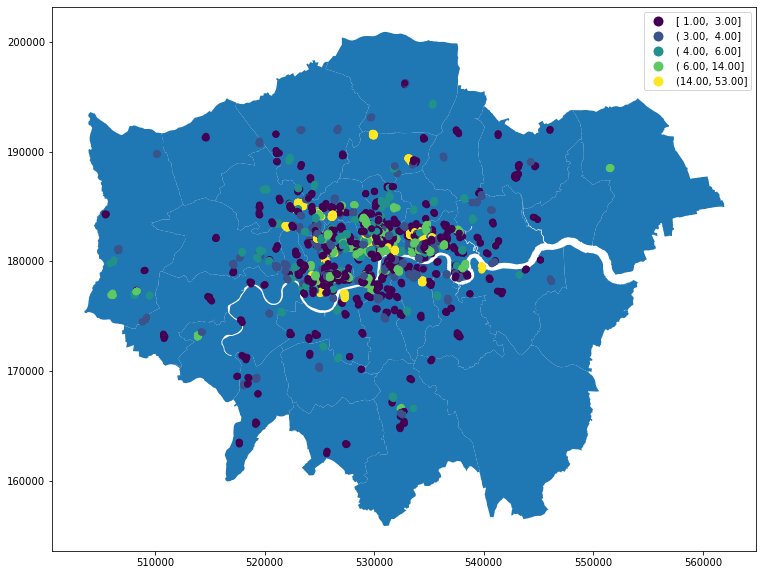

In [31]:
geo_gh_total = gpd.GeoDataFrame(geo_gh_total, geometry='geometry', crs='epsg:27700')

fig, ax = plt.subplots(1,1, figsize=(15,10))
boros.plot(ax=ax)
geo_gh_total.plot(ax=ax, column='count', scheme='quantiles', legend=True)

### Mapping percentage of listings in each borough that are ghost hotels

## Borough-level analysis

In [35]:
gdf_la = gpd.sjoin(gdf, boros, op='within', how='left')
gdf_la.drop(columns=['index_right','HECTARES','NONLD_AREA','ONS_INNER'], inplace=True)

In [36]:
#Drop listings that fall on the border between boroughs - there are only 5
gdf_la.drop(index=gdf_la[gdf_la.NAME.isnull()].index.values, axis=1, inplace=True) #5
print(gdf_la.shape)

(33299, 22)


In [37]:
#Find percentage of ghost hotels per borough
ghost_agg = gdf_la.groupby('GSS_CODE').agg({'is_ghost_listing': ['count', 'sum']})
ghost_agg.columns = ghost_agg.columns.droplevel(0)
ghost_agg['pc_ghost'] = ghost_agg.apply(lambda x: (x['sum']/x['count'])*100, axis=1)
boros = pd.merge(boros, ghost_agg, left_on='GSS_CODE', right_index=True)

In [38]:
#Find number of entire homes per borough
eh_agg = gdf_la.pivot_table(index='GSS_CODE', columns='room_type', aggfunc='size')
boros = pd.merge(boros, eh_agg, left_on='GSS_CODE', right_index=True)

In [39]:
#Load in bedroom and property data for boroughs
boro_properties = pd.read_csv('https://github.com/caranvr/i2p-assessment/raw/main/filtered_bedrooms_boros.csv')
boros = pd.merge(boros, boro_properties, left_on='GSS_CODE', right_on='ECODE')

In [40]:
boros['pc_eh'] = boros.apply(lambda x: (x['Entire home/apt']/x['ALL_PROPERTIES']*100), axis=1)

<AxesSubplot:>

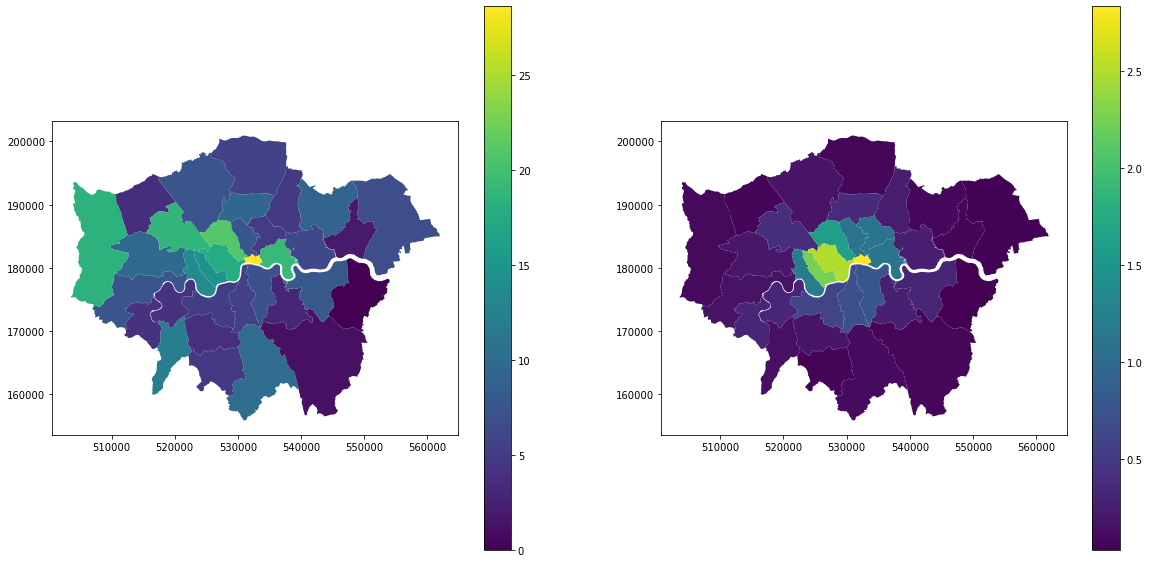

In [41]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
boros.plot(column='pc_ghost',
          legend=True,
          ax=axes[0])
boros.plot(column='pc_eh',
          legend=True,
          ax=axes[1])

### Mapping percentage of ghost-hotel listings in each LSOA

In [42]:
#Get LSOAs and extract LSOAs that are in London
lsoas = gpd.read_file('https://github.com/caranvr/i2p-assessment/blob/main/Lower_Layer_Super_Output_Area__December_2011__EW_BSC_V2-shp.zip?raw=true')

#Dissolve LSOA boundaries by London boundary
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')

ldn_lsoas = gpd.sjoin(lsoas, ldn, op='within')
del(lsoas)

In [ ]:
ldn_lsoas.drop(columns='index_right', inplace=True)
gdf_lsoa = gpd.sjoin(
            gdf, 
            ldn_lsoas, 
            op='within')

lsoa_ghost_pc = gdf_lsoa.groupby('LSOA11CD').is_ghost_listing.apply(lambda x: (x.sum()/x.count())*100)
ldn_lsoas.set_index('LSOA11CD', inplace=True)
ldn_lsoas = pd.concat([ldn_lsoas, lsoa_ghost_pc], axis=1)

In [ ]:
#Find number of entire homes per LSOA
eh_agg_lsoa = gdf_lsoa.pivot_table(index='LSOA11CD', columns='room_type', aggfunc='size')
ldn_lsoas = pd.merge(ldn_lsoas, eh_agg_lsoa, left_index=True, right_index=True)

In [ ]:
#Load in property data for LSOAs
lsoa_properties = pd.read_csv('https://github.com/caranvr/i2p-assessment/blob/main/filtered_propertybp.csv?raw=true')
ldn_lsoas = pd.merge(ldn_lsoas, lsoa_properties, how='left', left_index=True, right_on='ECODE')
del(lsoa_properties)

In [ ]:
ldn_lsoas['Entire home/apt'] = ldn_lsoas['Entire home/apt'].fillna(0)

In [ ]:
ldn_lsoas['pc_eh'] = ldn_lsoas.apply(lambda x: x['Entire home/apt']/x['ALL_PROPERTIES']*100, axis=1)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(20,10))
ldn.plot(ax=axes[0],
              color='lightgrey')
ldn.plot(ax=axes[1],
              color='lightgrey')
ldn_lsoas.plot(column='is_ghost_listing',
               ax=axes[0],
               legend=True)
ldn_lsoas.plot(column='pc_eh',
               ax=axes[1],
               legend=True)

# Executive Briefing

## Background

Since 2015, short-term letting of entire homes in London has been limited to 90 nights per year, a move to protect residential housing supply from the growing home-sharing market (Cosh, 2020). Airbnb has enforced this rule since 2017, automatically suspending bookings for entire-home listings that been booked for 90 days in a year (KeyNest, 2019). However, recent media and policy investigations have identified a new way for commercial short-term rental (STR) operators to skirt this regulation: the operation of 'ghost hotels', which are clusters of unlicensed STRs in the same building. 

Ghost hotels can take two different forms, which take advantage of different loopholes in London's STR limit. The first type of ghost hotel is the **entire-home ghost hotel**. These ghost hotels consist of multiple flats in the same building, each of which are either listed on home-sharing platforms at different times of the year, or listed multiple times with mirrored photos to avoid detection. This ensures that while no individual flat is recorded as let for more than 90 days per year, operators can profit from listings year-round. A recent _Wired_ investigation found that some of London's entire-home ghost hotels operate at a similar scale to traditional hotels: a ghost hotel block in Battersea, which has since been removed from Airbnb, consisted of at least twenty flats (Temperton, 2020). 

The second type of ghost hotel is the **private-room ghost hotel**, which was first identified in New York City by urban policy researchers at McGill University (Wachsmuth _et al._, 2018). These ghost hotels encompass one or more apartments in a building, with each room listed separately on Airbnb. In London, private-room ghost hotels take advantage of the fact that only entire-home listings are monitored on Airbnb (KeyNest, 2019). 

### Why focus on ghost hotels?

The existence of private-room ghost hotels in London suggests that STRs are putting more pressure on the city's housing market than is estimated. In the latest Greater London Authority (GLA) report on short-term lettings, the proportion of dwelling stock made up of entire-home listings is used as an indicator of how much housing supply has been lost to Airbnb (Cosh, 2020). This metric does not include flats that have been converted to multiple private-room listings (Wachsmuth _et al._, 2018). With an understanding of the extent of private-room ghost hotels, policymakers can improve the accuracy of housing supply estimates, which are important for housing and STR policy.

Analysing the extent of ghost hotels more broadly is also important, but for ensuring the health of London's communities. While commercial operators of spatially dispersed STRs may violate London's short-term letting laws in similar ways to ghost hotel operators, the density of STRs in ghost hotels, regardless of type, poses a unique threat to local residents' quality of life. In Lisbon and Amsterdam, residents of neighbourhoods with high concentrations of STRs have complained of overcrowding; construction noise from conversions of flats to STRs; the replacement of local shops and restaurants with tourist-oriented businesses; and disintegration of community relations as long-term residents are replaced by travelers (Pinkster and Boterman, 2017; Cocola-Gant and Gago, 2018).

### Report objectives

- Evaluate which form of ghost hotel is a larger threat to local quality of life in London
    - Analyse position of each type of ghost hotel in the local Airbnb market (each type analysed separately)
    - Analyse the spatial distribution of ghost-hotel listings (combined)
    - 

## The ghost hotel market: an overview

In August 2020, there were a total of 815 ghost hotels in London, comprising 3,854 listings. Between August 2019 and August 2020, these hotels generated over 27.5 million GBP in revenue. The ghost hotel market is dominated by entire-home ghost hotels. While entire-home ghost hotels make up only a slim majority (59.6%) of all ghost hotels in London, they earned 72.5% of total revenue between August 2019 and August 2020. 

In [ ]:
hotel_type_grouped

Ghost hotels accounted for a fairly small proportion of the Airbnb market, composing 11.57% of all listings and generating 12.82% of the year's total revenue (excluding listings that were deleted during the year). Entire-home ghost listings account for a similar share of the market for listings of the same room type. Private-room ghost listings account for slightly less of the market for their room type, at only 10.9%. This is a fairly low figure in comparison to New York City, where private-room ghost hotels make up 16% of all private-room listings (Wachsmuth _et al._, 2018). 

However, on average, both types of ghost listings are more lucrative than listings of their respective room types, particularly private-room ghost listings. The median revenue earned by private-room ghost listings between August 2019 and 2020 (£3,466) was 67% higher than that of all other private-room listings.

## Ghost hotels are concentrated in areas with low overall Airbnb density

If ghost hotels were to pose a more significant threat to quality of life in London than other types of Airbnb listings, these hotels would comprise a large proportion of listings in areas where STRs occupy a larger share of dwelling stock than elsewhere in the city. However, as the map below shows, this is only true for one borough: the City of London.

## Ghost hotels are concentrated in areas with low overall Airbnb density

Necessary information:
- Both types of ghost hotels are considered together in this analysis, as they have similar impacts on local quality of life
- **Map of ghost hotels, colored according to the number of listings associated with the ghost hotel**